In [1]:
import pandas as pd

df = pd.read_csv('../dados/acordaos-unicos-filtrados-500.csv', sep = '|')
df['filtrado_500']=df['filtrado_500'].astype(str)
df.head()

,acordao,areas,filtrado_500
0,297/2016-P,Responsabilidade,conta conta gerência instituto nacional seguro...
1,366/2016-P,Finanças Públicas,senado petróleo petróleo regime aduaneiro expo...
2,944/2016-P,Responsabilidade,tribunal conta plenário embargo declaração aco...
3,30/2016-P,Direito Processual,embargo declaração inss recorrente marco antôn...
4,55/2016-P,Pessoal,senac senac senac empresa senac giselle araújo...


In [2]:
df.shape

(9739, 3)

In [3]:
from sklearn.preprocessing import LabelBinarizer

areas = df.groupby(['areas']).groups.keys()
lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
lbArea.classes_

array(['Competência do TCU', 'Contrato Administrativo', 'Convênio',
       'Desestatização', 'Direito Processual', 'Finanças Públicas',
       'Gestão Administrativa', 'Licitação', 'Pessoal',
       'Responsabilidade'], dtype='<U23')

In [4]:
y = lbArea.transform(df['areas'])
y.shape

(9739, 10)

In [5]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 35000
limite_texto = 500
dim_vetor = 100

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['filtrado_500'])

sequences = tokenizer.texts_to_sequences(df['filtrado_500'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 32293 unique tokens.


In [6]:
max = 0
lens = []
for seq in sequences:
    lens.append(len(seq))
np.min(lens), np.mean(lens), np.max(lens), np.std(lens), len(lens), sum(pd.Series(lens) > 40000), sum(pd.Series(lens) > 40000)/len(lens)

(1, 473.38186672142933, 687, 55.885683817791985, 9739, 0, 0.0)

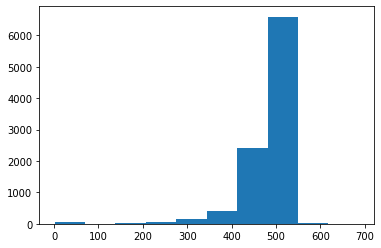

In [8]:
import matplotlib.pyplot as plt
plt.hist(lens)
plt.show()
plt.show()

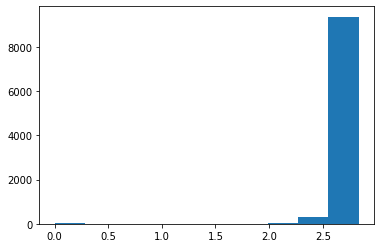

In [9]:
plt.hist(np.log10(lens))
plt.show()
plt.show()

In [10]:
np.percentile(lens, 25), np.percentile(lens, 50), np.percentile(lens, 75), np.percentile(lens, 90), np.percentile(lens, 95)

(474.0, 492.0, 498.0, 500.0, 500.0)

In [11]:
np.mean(np.log10(lens)), 10**np.mean(np.log10(lens)), np.std(np.log10(lens)), (np.mean(np.log10(lens)) + 2*np.std(np.log10(lens))), 10**(np.mean(np.log10(lens)) + 2*np.std(np.log10(lens)))

(2.66074705885708,
 457.8751340901256,
 0.2013987397645056,
 3.063544538386091,
 1157.5627380274227)

In [12]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (9739, 500)


In [13]:
x.shape, y.shape

((9739, 500), (9739, 10))

In [14]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

W0312 10:59:55.453653 140715089782592 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0312 10:59:55.473144 140715089782592 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0312 10:59:55.474920 140715089782592 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0312 10:59:55.504092 140715089782592 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is d

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          3500000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              102402048 
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total para

In [15]:
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W0312 11:00:32.290031 140715089782592 deprecation.py:323] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7791 samples, validate on 1948 samples
Epoch 1/20
7791/7791 [==============================] - 33s 4ms/step - loss: 1.1832 - categorical_accuracy: 0.6027 - val_loss: 1.3125 - val_categorical_accuracy: 0.5544
Epoch 2/20
7791/7791 [==============================] - 30s 4ms/step - loss: 0.5224 - categorical_accuracy: 0.8279 - val_loss: 1.4384 - val_categorical_accuracy: 0.5621
Epoch 3/20
7791/7791 [==============================] - 30s 4ms/step - loss: 0.1195 - categorical_accuracy: 0.9687 - val_loss: 1.9228 - val_categorical_accuracy: 0.5287
Epoch 4/20
7791/7791 [==============================] - 30s 4ms/step - loss: 0.0422 - categorical_accuracy: 0.9891 - val_loss: 2.0401 - val_categorical_accuracy: 0.5683
Epoch 5/20
7791/7791 [==============================] - 30s 4ms/step - loss: 0.0281 - categorical_accuracy: 0.9918 - val_loss: 2.5576 - val_categorical_accuracy: 0.5436
Epoch 6/20
7791/7791 [==============================] - 30s 4ms/step - loss: 0.0300 - categorical_accuracy: